In [9]:
from __future__ import print_function
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import pandas_datareader as data 
from pykalman import KalmanFilter

In [112]:
def calc_slope_intercept_kalman(crypto, prices): 
    """
    Utilise the Kalman Filter from the PyKalman package
    to calculate the slope and intercept of the regressed
    ETF prices.
    """
    delta = 1e-5
    trans_cov = delta / (1 - delta) * np.eye(2)
    obs_mat = np.vstack([prices[crypto[0]], np.ones(prices[crypto[0]].shape)] ).T[:, np.newaxis]
    
    kf = KalmanFilter(n_dim_obs=1,n_dim_state=2,initial_state_mean=np.zeros(2),
                      initial_state_covariance=np.ones((2, 2)),transition_matrices=np.eye(2),
                      observation_matrices=obs_mat,observation_covariance=1.0,transition_covariance=trans_cov)

    state_means, state_covs = kf.filter(prices[crypto[1]].values)
    return state_means, state_covs

In [116]:
def draw_slope_intercept_changes(prices, state_means): 
    """
    Plot the slope and intercept changes from the Kalman Filter calculated values.
    """
    pd.DataFrame(dict(slope=state_means[:, 0],
                intercept=state_means[:, 1]), index=prices.index).plot(subplots=True, figsize=(20,15))
    
    plt.show()

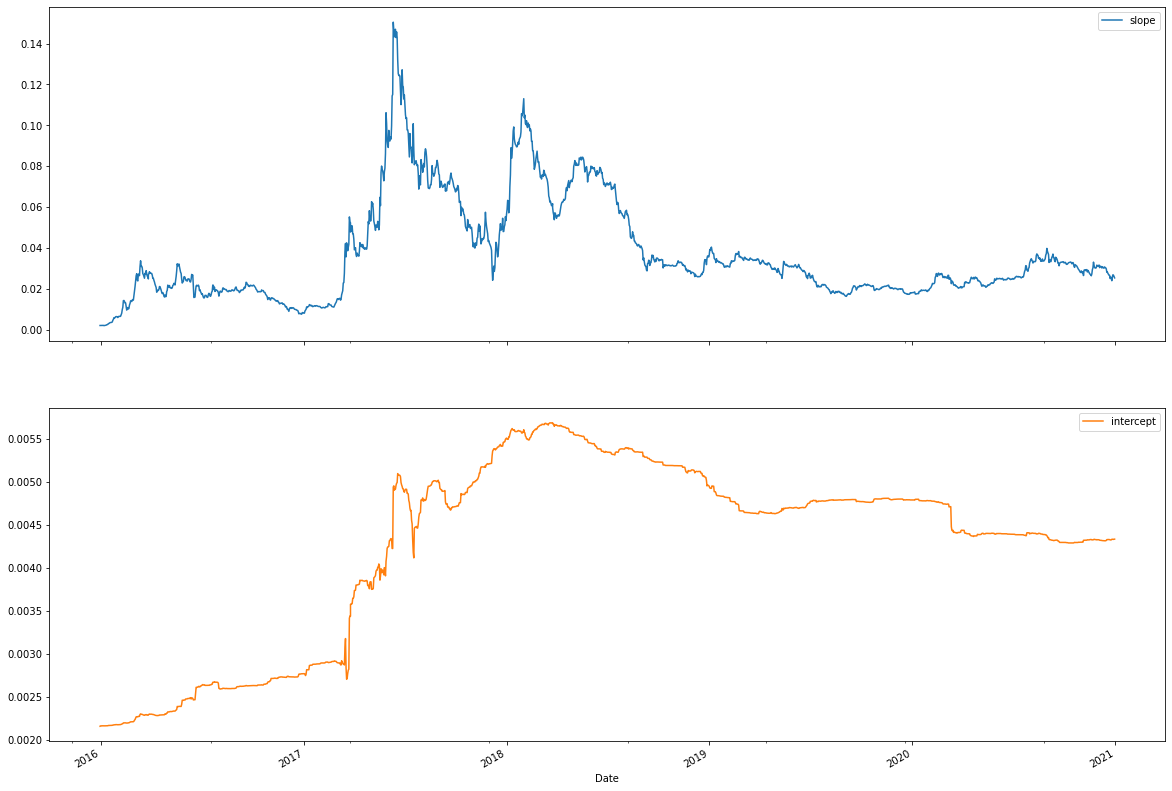

In [117]:
if __name__ == "__main__":
    # Choose the ETF symbols to work with along with # start and end dates for the price histories etfs = [’TLT’, ’IEI’]
    start_date = "2016-01-01"
    end_date = "2020-12-31"
    # Obtain the adjusted closing prices from Yahoo finance
    ethereum_df = data.get_data_yahoo('ETH-USD', start_date, end_date) 
    bitcoin_df  = data.get_data_yahoo('BTC-USD', start_date, end_date)
    prices = pd.DataFrame(index=ethereum_df.index)
    prices['ETH-USD'] = ethereum_df["Adj Close"]
    prices['BTC-USD'] = bitcoin_df["Adj Close"]
    crypto = ['BTC-USD', 'ETH-USD']
    #draw_date_coloured_scatterplot(crypto, prices)
    state_means, state_covs = calc_slope_intercept_kalman(crypto, prices) 
    draw_slope_intercept_changes(prices, state_means)

In [217]:
from __future__ import print_function
from collections import deque 
from math import floor
import numpy as np
from qstrader.event import (SignalEvent, EventType) 
from qstrader.strategy.base import AbstractStrategy

class CointegrationBollingerBandsStrategy(AbstractStrategy): 
    """
    Requires: 
    tickers - The list of ticker symbols
    events_queue - A handle to the system events queue lookback - Lookback period for moving avg and moving std weights - The weight vector describing
    a "unit" of the portfolio
    entry_z - The z-score trade entry threshold
    exit_z - The z-score trade exit threshold
    base_quantity - Number of "units" of the portfolio
        to be traded
    """
    def __init__(self, tickers, events_queue, lookback, lookback2, weights, entry_z, exit_z, base_quantity):
        self.tickers = tickers
        self.events_queue = events_queue
        self.lookback = lookback
        self.lookback2 = lookback2
        self.weights = weights
        self.entry_z = entry_z
        self.exit_z = exit_z
        self.qty = base_quantity
        self.time = None
        self.latest_prices = np.full(len(self.tickers), -1.0) 
        self.port_mkt_val = deque(maxlen=self.lookback)
        self.port_lat_val = deque(maxlen=self.lookback2)
        self.invested = None
        self.bars_elapsed = 0
        
        # Kalman filter initialization
        self.delta = 1e-5
        self.wt = self.delta / (1 - self.delta) * np.eye(2)
        self.vt = 1e-3
        self.theta = np.zeros(2)
        self.P = np.zeros((2, 2))
        self.R = None
        self.theta_list = []
        

    def _set_correct_time_and_price(self, event):
        """
        Sets the correct price and event time for prices that arrive out of order in the events queue. """
        # Set the first instance of time
        if self.time is None:
            self.time = event.time
        # Set the correct latest prices depending upon # order of arrival of market bar event
        price = event.adj_close_price
        if event.time == self.time:
            for i in range(0, len(self.tickers)):
                if event.ticker == self.tickers[i]: self.latest_prices[i] = price
        else:
            self.time = event.time
            self.bars_elapsed += 1
            self.latest_prices = np.full(len(self.tickers), -1.0) 
            for i in range(0, len(self.tickers)):
                if event.ticker == self.tickers[i]: self.latest_prices[i] = price

    def go_long_units(self): 
        """
        Go long the appropriate number of "units" of the
        portfolio to open a new position or to close out
        a short position.
        """
        for i, ticker in enumerate(self.tickers): 
            if self.weights[i] < 0.0:
                self.events_queue.put(SignalEvent(ticker, "SLD",int(floor(-1.0*self.qty*self.final_weight_hedge))) )

            else: 
                self.events_queue.put(SignalEvent(ticker, "BOT",int(floor(self.qty*self.weights[i]))))
            
                
    def go_short_units(self):
        """
        Go short the appropriate number of "units" of the portfolio to open a new position or to close out a long position.
        """
        for i, ticker in enumerate(self.tickers):
            if self.weights[i] < 0.0: 
                self.events_queue.put(SignalEvent(ticker, "BOT",int(floor(-1.0*self.qty*self.final_weight_hedge))) )
            else: 
                self.events_queue.put(SignalEvent(ticker, "SLD",int(floor(self.qty*self.weights[i]))))
                
                
    def zscore_trade(self, zscore, event): 
        """
        Determine whether to trade if the entry or exit zscore
        threshold has been exceeded.
        """
        # If we’re not in the market...
        if self.invested is None:
            if zscore < -self.entry_z:
                self.final_weight_hedge = float(-1*round(self.theta[0], 4))
                # Long Entry
                print("LONG: %s" % event.time) 
                self.go_long_units() 
                self.invested = "long"
                
            elif zscore > self.entry_z: # Short Entry
                self.final_weight_hedge = float(-1*round(self.theta[0], 4))
                print("SHORT: %s" % event.time) 
                self.go_short_units() 
                self.invested = "short"
            
        # if we are in the market...
        if self.invested is not None:
            
            if self.invested == "long" and zscore >= -self.exit_z:
                print("CLOSING LONG: %s" % event.time) 
                self.go_short_units()
                self.invested = None
            elif self.invested == "short" and zscore <= self.exit_z: 
                print("CLOSING SHORT: %s" % event.time) 
                self.go_long_units()
                self.invested = None
                
    def calculate_signals(self, event):
        """
        Calculate the signals for the strategy. """
        if event.type == EventType.BAR:
            self._set_correct_time_and_price(event)
            # Only trade if we have all prices
            if all(self.latest_prices > -1.0): 
                # Create the observation matrix of the latest prices
                # of Bitcoin(BTC-USD) and the intercept value (1.0) as well as the
                # scalar value of the latest price from Ethereum (ETH-USD)
                F = np.asarray([self.latest_prices[1], 1.0]).reshape((1, 2))
                y = self.latest_prices[0]

                # The prior value of the states \theta_t is
                # distributed as a multivariate Gaussian with
                # mean a_t and variance-covariance R_t
                if self.R is not None:
                    self.R = self.C + self.wt
                else:
                    self.R = np.zeros((2, 2))

                # Calculate the Kalman Filter update
                # ----------------------------------
                # Calculate prediction of new observation
                # as well as forecast error of that prediction
                yhat = F.dot(self.theta)
                et = y - yhat

                # Q_t is the variance of the prediction of
                # observations and hence \sqrt{Q_t} is the
                # standard deviation of the predictions
                Qt = F.dot(self.R).dot(F.T) + self.vt
                sqrt_Qt = np.sqrt(Qt)

                # The posterior value of the states \theta_t is
                # distributed as a multivariate Gaussian with mean
                # m_t and variance-covariance C_t
                At = self.R.dot(F.T) / Qt
                self.theta = self.theta + At.flatten() * et
                self.C = self.R - At * F.dot(self.R)
                
                # Append Kalman Filter theta weight to list and calculate the mean
                # We use the mean to smoothen the weights   
                self.theta_list.append(round(self.theta[0], 4))
                self.theta[0]=np.mean(self.theta_list)
                
                # update weights with Kalman Filter theta weight
                self.weights[1] = float(-1*round(self.theta[0], 4))
                
                # Generate the mean-reverting trading signal 
                # ------------------------------------
                # Calculate portfolio market value via dot product # of crypto prices with portfolio weights 
                self.port_mkt_val.append(np.dot(self.latest_prices, self.weights))
                # If there is enough data to form a full lookback # window, then calculate zscore and carry out
                # respective trades if thresholds are exceeded
                self.port_lat_val.append(np.dot(self.latest_prices, self.weights))
                if self.bars_elapsed > self.lookback2:
                    zscore = (np.mean(self.port_lat_val) - np.mean(self.port_mkt_val)) / np.std(self.port_mkt_val)
                    self.zscore_trade(zscore, event)
                

Running Backtest...
LONG: 2016-03-12 00:00:00
CLOSING LONG: 2016-04-10 00:00:00
SHORT: 2016-04-12 00:00:00
CLOSING SHORT: 2016-05-20 00:00:00
LONG: 2016-05-21 00:00:00
CLOSING LONG: 2016-06-20 00:00:00
SHORT: 2016-06-25 00:00:00
CLOSING SHORT: 2016-08-29 00:00:00
LONG: 2016-09-13 00:00:00
CLOSING LONG: 2016-10-11 00:00:00
SHORT: 2016-10-12 00:00:00
CLOSING SHORT: 2017-01-14 00:00:00
LONG: 2017-01-15 00:00:00
CLOSING LONG: 2017-07-13 00:00:00
SHORT: 2017-07-16 00:00:00
CLOSING SHORT: 2017-08-25 00:00:00
LONG: 2017-08-30 00:00:00
CLOSING LONG: 2017-09-11 00:00:00
SHORT: 2017-09-12 00:00:00
CLOSING SHORT: 2017-12-22 00:00:00
LONG: 2017-12-23 00:00:00
CLOSING LONG: 2018-02-24 00:00:00
SHORT: 2018-02-25 00:00:00
CLOSING SHORT: 2018-04-29 00:00:00
LONG: 2018-04-30 00:00:00
CLOSING LONG: 2018-06-13 00:00:00
SHORT: 2018-06-14 00:00:00
CLOSING SHORT: 2018-11-11 00:00:00
LONG: 2018-11-12 00:00:00
CLOSING LONG: 2019-03-26 00:00:00
SHORT: 2019-04-05 00:00:00
CLOSING SHORT: 2019-09-19 00:00:00
LONG

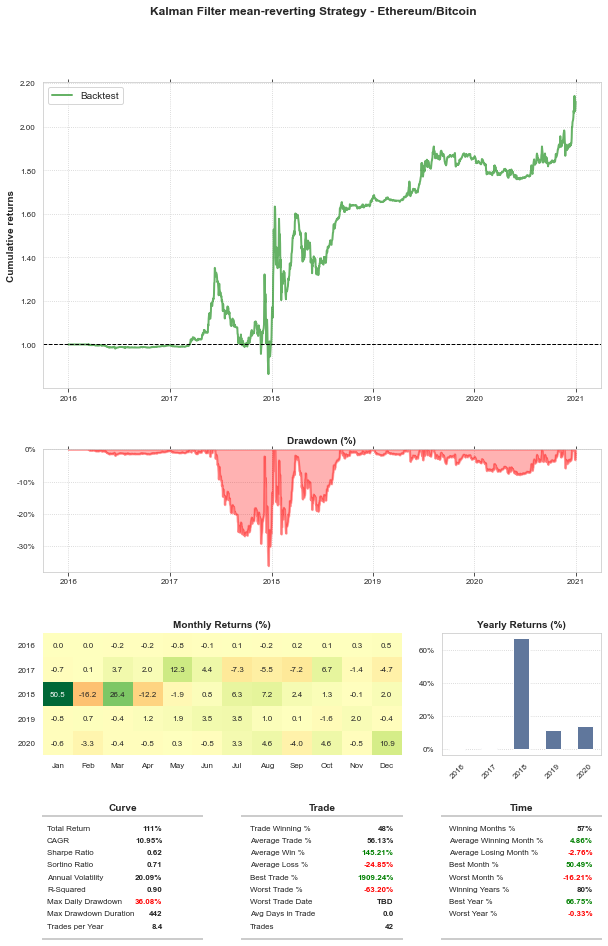

saving plots to output directory


In [218]:
from munch import munchify
import datetime 
import click
import numpy as np
import queue 
from qstrader.price_handler.yahoo_daily_csv_bar import YahooDailyCsvBarPriceHandler
from qstrader.execution_handler.ib_simulated import IBSimulatedExecutionHandler
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading_session import TradingSession
from qstrader.portfolio_handler import PortfolioHandler
from qstrader.compliance.example import ExampleCompliance
import warnings
warnings.filterwarnings('ignore')


def run(config, tickers, filename):
    # Set up variables needed for backtest
    events_queue = queue.Queue()
    csv_dir = config.CSV_DATA_DIR
    initial_equity = 10000000.00
   
    # Use Yahoo Daily Price Handler
    start_date = datetime.datetime(2016, 1, 1) 
    end_date = datetime.datetime(2020, 12, 31) 
    price_handler = YahooDailyCsvBarPriceHandler(csv_dir, events_queue, tickers,start_date=start_date, 
                                                 end_date=end_date)
    # Hedge ratio between Ethereum and Bitcoin
    weights = np.array([1.0, -1.0])
    # Hyperparameters tuning
    lookback = 5
    lookback2 = 70
    entry_z = 3.0
    exit_z = -2.0
    # base quantity traded
    base_quantity = 10000
    # Run Bollinger Bands strategy
    strategy = CointegrationBollingerBandsStrategy(tickers, events_queue,lookback, lookback2, weights,
                                                   entry_z, exit_z, base_quantity)
    
    # Use portfolio handler
    portfolio_handler = PortfolioHandler(initial_equity, events_queue, price_handler) 
    
    # Use the ExampleCompliance component
    compliance = ExampleCompliance(config)
    # Use a simulated IB Execution Handler
    execution_handler = IBSimulatedExecutionHandler( events_queue, price_handler, compliance)
    # Use the Tearsheet Statistics
    title = ["Kalman Filter mean-reverting Strategy - Ethereum/Bitcoin"]
    statistics = TearsheetStatistics(config, portfolio_handler, title)
    
    # Set up the backtest
    backtest = TradingSession(config, tickers, start_date, end_date, events_queue, session_type="backtest",
                              price_handler=price_handler,end_session_time=None,compliance=compliance, 
                              strategy=strategy, portfolio_handler=portfolio_handler, 
                              execution_handler=execution_handler, statistics=statistics , 
                              initial_equity=initial_equity, title=title, benchmark=None)
    
    results = backtest.start_trading() 
    statistics.save(filename)
    return results
                        # Change below to your own directory, 
                        # Please also change the tradelog directory from example.py
def main(config=munchify({"CSV_DATA_DIR": '/Users/AndyTan/Documents/cointegration_crypto'+"/data", 
                          "OUTPUT_DIR":'/Users/AndyTan/Documents/cointegration_crypto'+"/out"}),
         tickers="ETH-USD,BTC-USD", filename=""):
    tickers = tickers.split(",")
    run(config, tickers, filename)
    
if __name__ == "__main__":
    main()